In [2]:
# importing necessary librarys
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.datasets import (make_blobs, make_circles, make_moons)
import random
from matplotlib.animation import FuncAnimation

# Task:
* Choose >8 variables, where >=2 are numerical and >=2 are categorical, that correlate to the target variable in question ('SalePrice').
    * For each variabe:
        * Describe how it can affect the sales price
        * What its type is (numerical/categorical)
        * Make a data quality report
            * Continuous var.:
                1) Count - amount of total observations
                2) % missing - percent of N/A observations
                3) Cardinality - number of unique observations
                4) Min value - lowest observation
                5) Q1 (first quartile value) - in an ordered set of observations, the value at that separates the first 25% of data from the rest.
                6) Mean - the average of all observations.
                7) Median - in an ordered set of observations, the value in the middle.
                8) Q3 (third quartile value) - same as Q1 but at the 75% mark.
                9) Max - highest observation
                10) Standard deviation - statistic that tells us how the data is dispersed around the middle
                    * By calculating the standard deviation, we know the range of the values that surround the median.
                    * e.g. with 1 std. dev. we can estimate ~68 percent of values simply by subtracting or adding from to the median a value that is within the range bound by a negative and positive std. dev.
            * Categorical var.:
                1) Count - amount of total observations
                2) % missing - percent of N/A observations
                3) Cardinality - number of unique observations
                4) Mode - the most frequent value
                5) Mode frequency - amount of times the mode appears
                6) Mode % - percent of the observations that are the value of the mode
                7) 2nd Mode - value of the 2nd largest mode
                8) 2nd Mode % - percent of values the 2nd largest mode takes up in the observations
            * *Program calculations of **mathematical** values by hand*
        * Draw Histogram/Bar chart
        * Draw a boxplot
    * Draw >=3 scatterplots for chosen variables
* Realize a KNN

# Initialization

In [16]:
df = pd.read_csv("data/train.csv",sep=",",na_values=['NA'])
my_col = ['SalePrice', 'LotArea', 'Condition1', 'OverallQual', 'LotFrontage',
          'YearBuilt', 'YearRemodAdd', 'CentralAir', 'ExterCond'] 

df.info(show_counts=True)

for col in my_col:
    print(col, '\n', df[col].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             999 non-null    int64  
 1   MSSubClass     999 non-null    int64  
 2   MSZoning       999 non-null    object 
 3   LotFrontage    826 non-null    float64
 4   LotArea        999 non-null    int64  
 5   Street         999 non-null    object 
 6   Alley          65 non-null     object 
 7   LotShape       999 non-null    object 
 8   LandContour    999 non-null    object 
 9   Utilities      999 non-null    object 
 10  LotConfig      999 non-null    object 
 11  LandSlope      999 non-null    object 
 12  Neighborhood   999 non-null    object 
 13  Condition1     999 non-null    object 
 14  Condition2     999 non-null    object 
 15  BldgType       999 non-null    object 
 16  HouseStyle     999 non-null    object 
 17  OverallQual    999 non-null    int64  
 18  OverallCon

# Variables chosen:

1) SalePrice - the property's sale price in dollars. 
    - Reason - ***Target variable to predict***
    - Type - Numerical discrete(dtype: float64) 

2) LotArea - Lot size in square feet
    - Reason - bigger the lot (land) size, bigger the value
    - Type - Numerical discrete (dtype: float64) 

3) Condition1 - Proximity to main road or railroad
    - Reason - if access to a main road is good or even greater, there is more appeal to people who would need to commute for work.
    - Type - Categorical nominal (could be seen as ordinal) (dtype: object) 

4) OverallQual - Overall material and finish quality
    - Reason - a house considered to be of better quality has more appeal then one with a worse quality.
    - Type - Numerical continuous (dtype: float64)

5) LotFrontage - Linear feet of street connected to property
    - Reason - mainly to showcase imputation of values.
    - Type - Numerical discrete (dtype: float64) 

6) YearBuilt - Original construction date
    - Reason - the newer the build of a house, the more "reliable" and modern it may seem.
        - Might have an adverse effect where antique houses can drive up the price.
    - Type - Numerical continuous (dtype: float64) 

7) YearRemodAdd - Remodel date
    - Reason - remodeled houses can have more appeal as there is no need for renowation.
    - Type - Numerical continuous (dtype: float64)

8) CentralAir - Central air conditioning
    - Reason - air conditioning is very prevalent in America, thus many people rely on it. If it is not present, there shouldn't be that much appeal, though I think this will mostly apply for cheaper houses.
    - Type - Categorical ordinal (in my opinion) (dtype: float64) 
        - A boolean 'Yes' or 'No' Value

9) ExterCond - Present condition of the material on the exterior
    - Reason - if the quality of the exterior is great, no urgent upkeep is needed in addition to the house being presented as of higher overall quality.
    - Type - Categorical ordinal (dtype: float64) 

# Data quality reports

In [4]:
t_cont = { # Data quality table for continuous variables
    'Feature' : ['SalePrice', 'LotArea', 'OverallQual', 'LotFrontage', 'YearBuilt', 'YearRemodAdd'],
    'Count' :[],
    '% Miss':[],
    'Card.':[],
    'Min':[],
    'Q1':[],
    'Mean':[],
    'Median':[],
    'Q3':[],
    'Max':[],
    'Std. Dev.':[]
}
t_cate = { # Data quality table for categorical variables
    'Feature' : ['Condition1', 'CentralAir', 'ExterCond'],
    'Count' : [],
    '% Miss' : [],
    'Card.' : [],
    'Mode' : [],
    'Mode freq.' : [],
    'Mode %' : [],
    '2nd Mode' : [],
    '2nd Mode freq.' : [],
    '2nd Mode %' : []
}

# Implemented my own calculations for clarity/experience
def get_report_cont(feature:str, t_cont):
    obs_raw = df[feature]
    obs = obs_raw.sort_values().reset_index(drop=True)
    count = obs.count()

    t_cont['Count'].append(count)
    t_cont['% Miss'].append((sum(obs.isna()) / len(obs)) *100)
    t_cont['Card.'].append(len(obs.unique()))
    t_cont['Min'].append(obs.min())
    # Q1 - median value between the actual median and the very first value
    t_cont['Q1'].append(obs.quantile(0.25))
    # Mean - average of all values
    t_cont['Mean'].append(obs.mean())
    # Median - middle value of the sorted set
    t_cont['Median'].append(obs.quantile(0.5, 'midpoint'))
    # Q3 - similar to Q1, but between the median and the very last value
    t_cont['Q3'].append(obs.quantile(0.75, 'lower'))
    t_cont['Max'].append(obs.max())
    # Standard deviation - metric that tells us how far the data is spread out from the median
    t_cont['Std. Dev.'].append(obs.std())

def get_report_cate(feature:str, t_cate):
    obs = df[feature]
    count = obs.count()

    value_counts = obs.value_counts() # gives array with modes and their frequencies
    mode_names = value_counts.index.tolist() # names of the modes
    mode_counts = value_counts.values # frequencies of the nodes

    t_cate['Count'].append(count)
    t_cate['% Miss'].append((sum(obs.isna()) / count) *100)
    t_cate['Card.'].append(len(obs.unique()))
    t_cate['Mode'].append(mode_names[0])
    t_cate['Mode freq.'].append(mode_counts[0])
    t_cate['Mode %'].append(mode_counts[0]/count*100)
    t_cate['2nd Mode'].append(mode_names[1])
    t_cate['2nd Mode freq.'].append(mode_counts[1])
    t_cate['2nd Mode %'].append(mode_counts[1]/count*100)

for feat in t_cont['Feature']:
    get_report_cont(feat, t_cont)

for feat in t_cate['Feature']:
    get_report_cate(feat, t_cate)

cont_df = pd.DataFrame(data=t_cont)
cate_df = pd.DataFrame(data=t_cate)
cont_df

,Feature,Count,% Miss,Card.,Min,Q1,Mean,Median,Q3,Max,Std. Dev.
0,SalePrice,999,0.000000,536,34900.0,130000.0,182260.711712,163990.0,215000.0,755000.0,80327.919925
1,LotArea,999,0.000000,780,1300.0,7589.0,10695.109109,9452.0,11625.0,215245.0,11417.706546
2,OverallQual,999,0.000000,10,1.0,5.0,6.124124,6.0,7.0,10.0,1.383632
3,LotFrontage,826,17.317317,103,21.0,60.0,69.962470,70.0,80.0,313.0,23.215821
4,YearBuilt,999,0.000000,107,1880.0,1954.0,1971.598599,1974.0,2000.0,2010.0,30.003240
5,YearRemodAdd,999,0.000000,61,1950.0,1967.0,1985.258258,1994.0,2004.0,2010.0,20.411974


In [5]:
cate_df

,Feature,Count,% Miss,Card.,Mode,Mode freq.,Mode %,2nd Mode,2nd Mode freq.,2nd Mode %
0,Condition1,999,0.0,9,Norm,861,86.186186,Feedr,54,5.405405
1,CentralAir,999,0.0,2,Y,931,93.193193,N,68,6.806807
2,ExterCond,999,0.0,5,TA,871,87.187187,Gd,103,10.310310


# Histograms

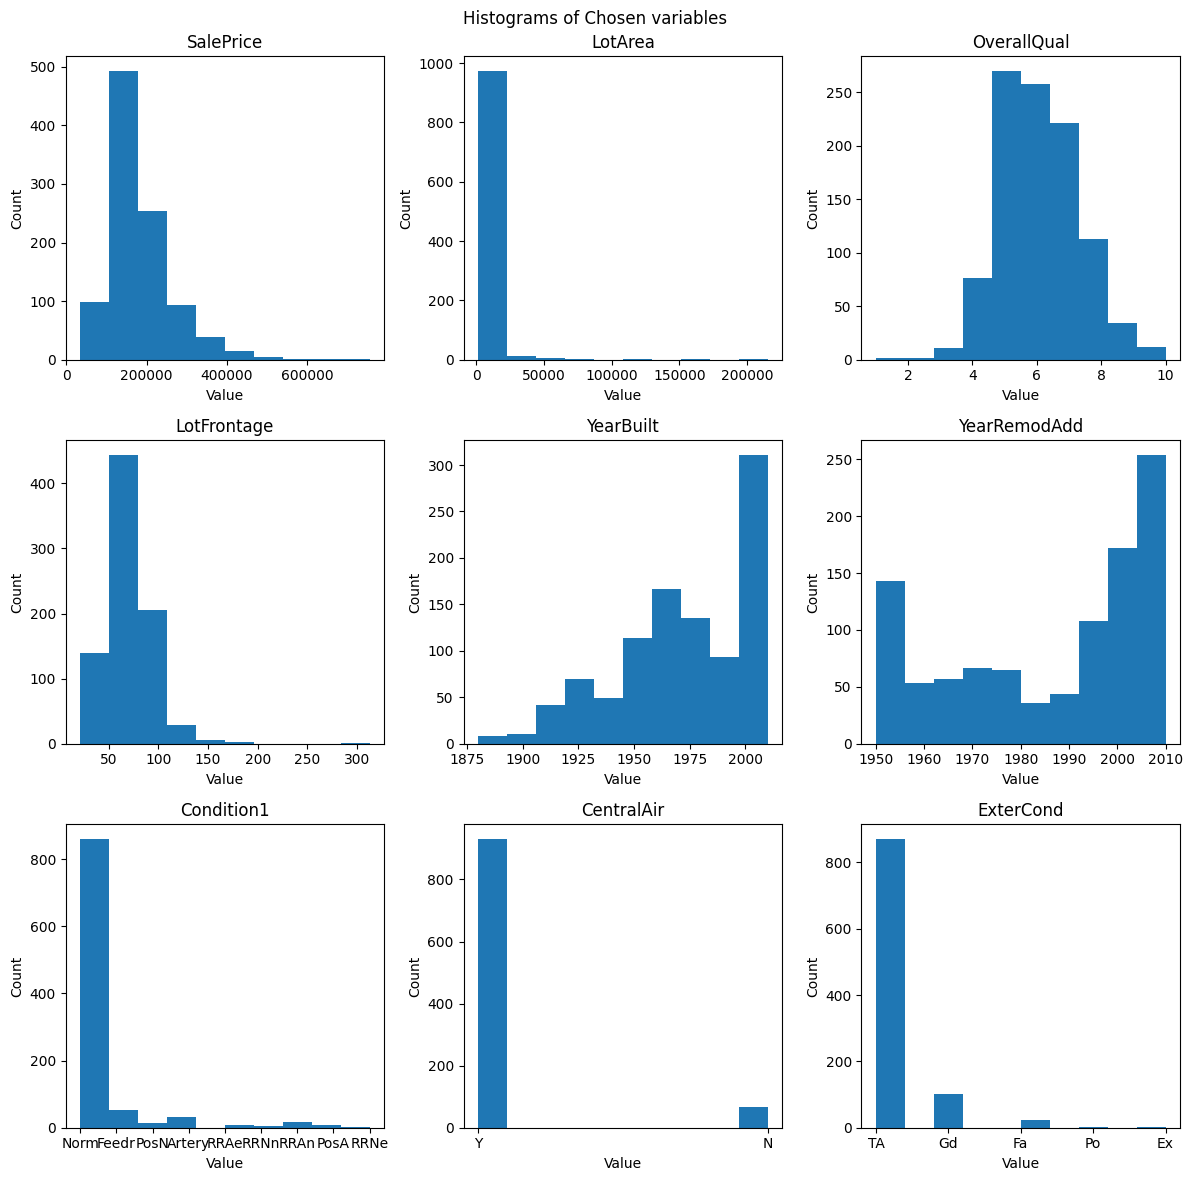

In [6]:
def print_histograms():
    fig, axes = plt.subplots(3, 3, figsize=(12,12))

    fig.suptitle("Histograms of Chosen variables")

    all_feat = []
    for f in t_cont['Feature']:
        all_feat.append(f)
    for f in t_cate['Feature']:
        all_feat.append(f)

    for feat, ax in zip(all_feat, axes.flatten()):
        ax.hist(df[feat])
        ax.set_xlabel('Value')
        ax.set_ylabel('Count')
        ax.set_title(feat)

    plt.tight_layout()
    plt.show()

print_histograms()

# Boxplots

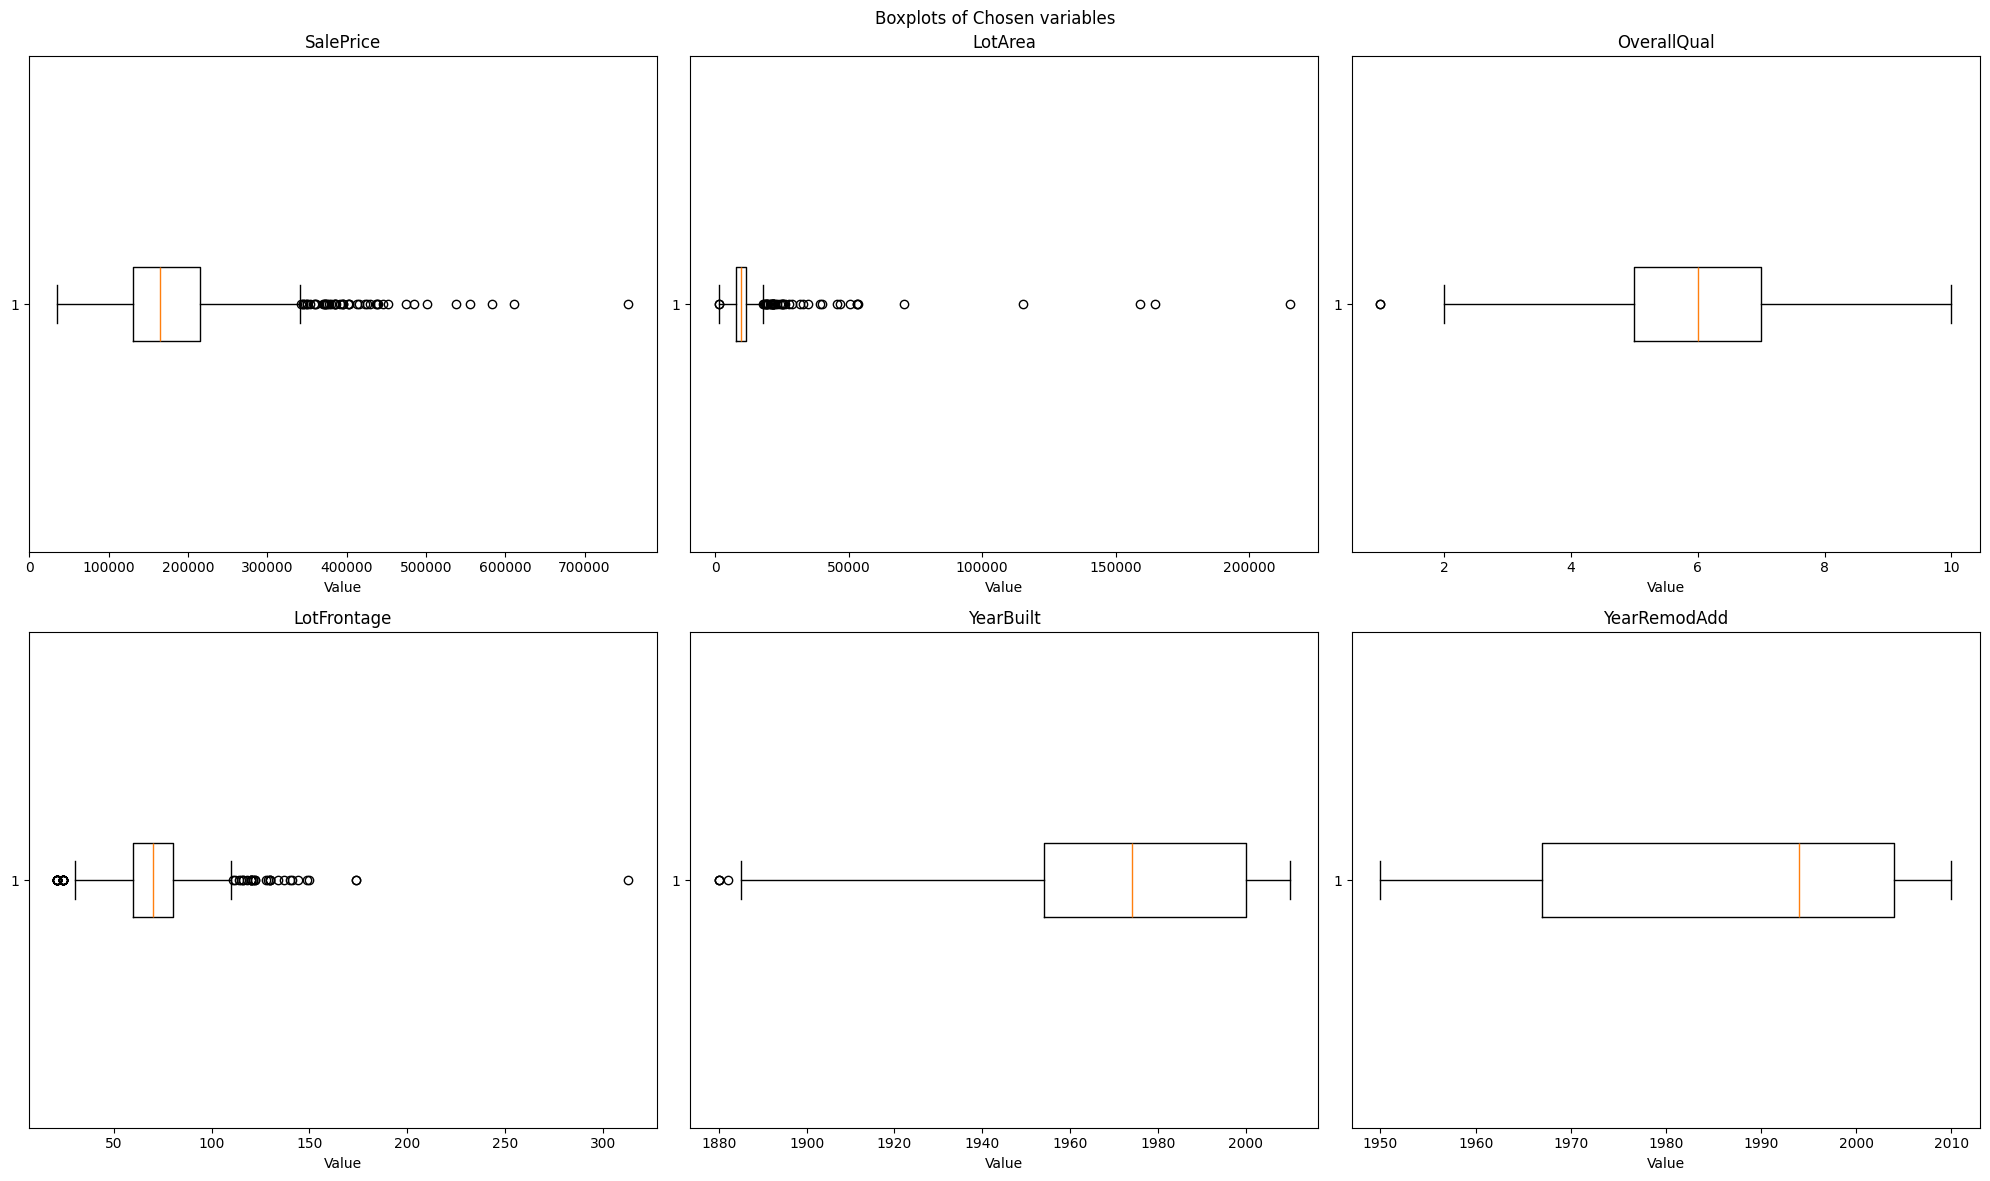

In [7]:
def print_boxplots():
    fig, axes = plt.subplots(2, 3, figsize=(20,12))

    fig.suptitle("Boxplots of Chosen variables")

    for feat, ax in zip(t_cont['Feature'], axes.flatten()):
        obs = df[feat].dropna().copy() # other wise box plot cannot be plotted
        ax.boxplot(obs, orientation='horizontal')
        ax.set_xlabel('Value')
        ax.set_title(feat)

    plt.tight_layout()
    plt.show()
    
print_boxplots()

# Scatterplots

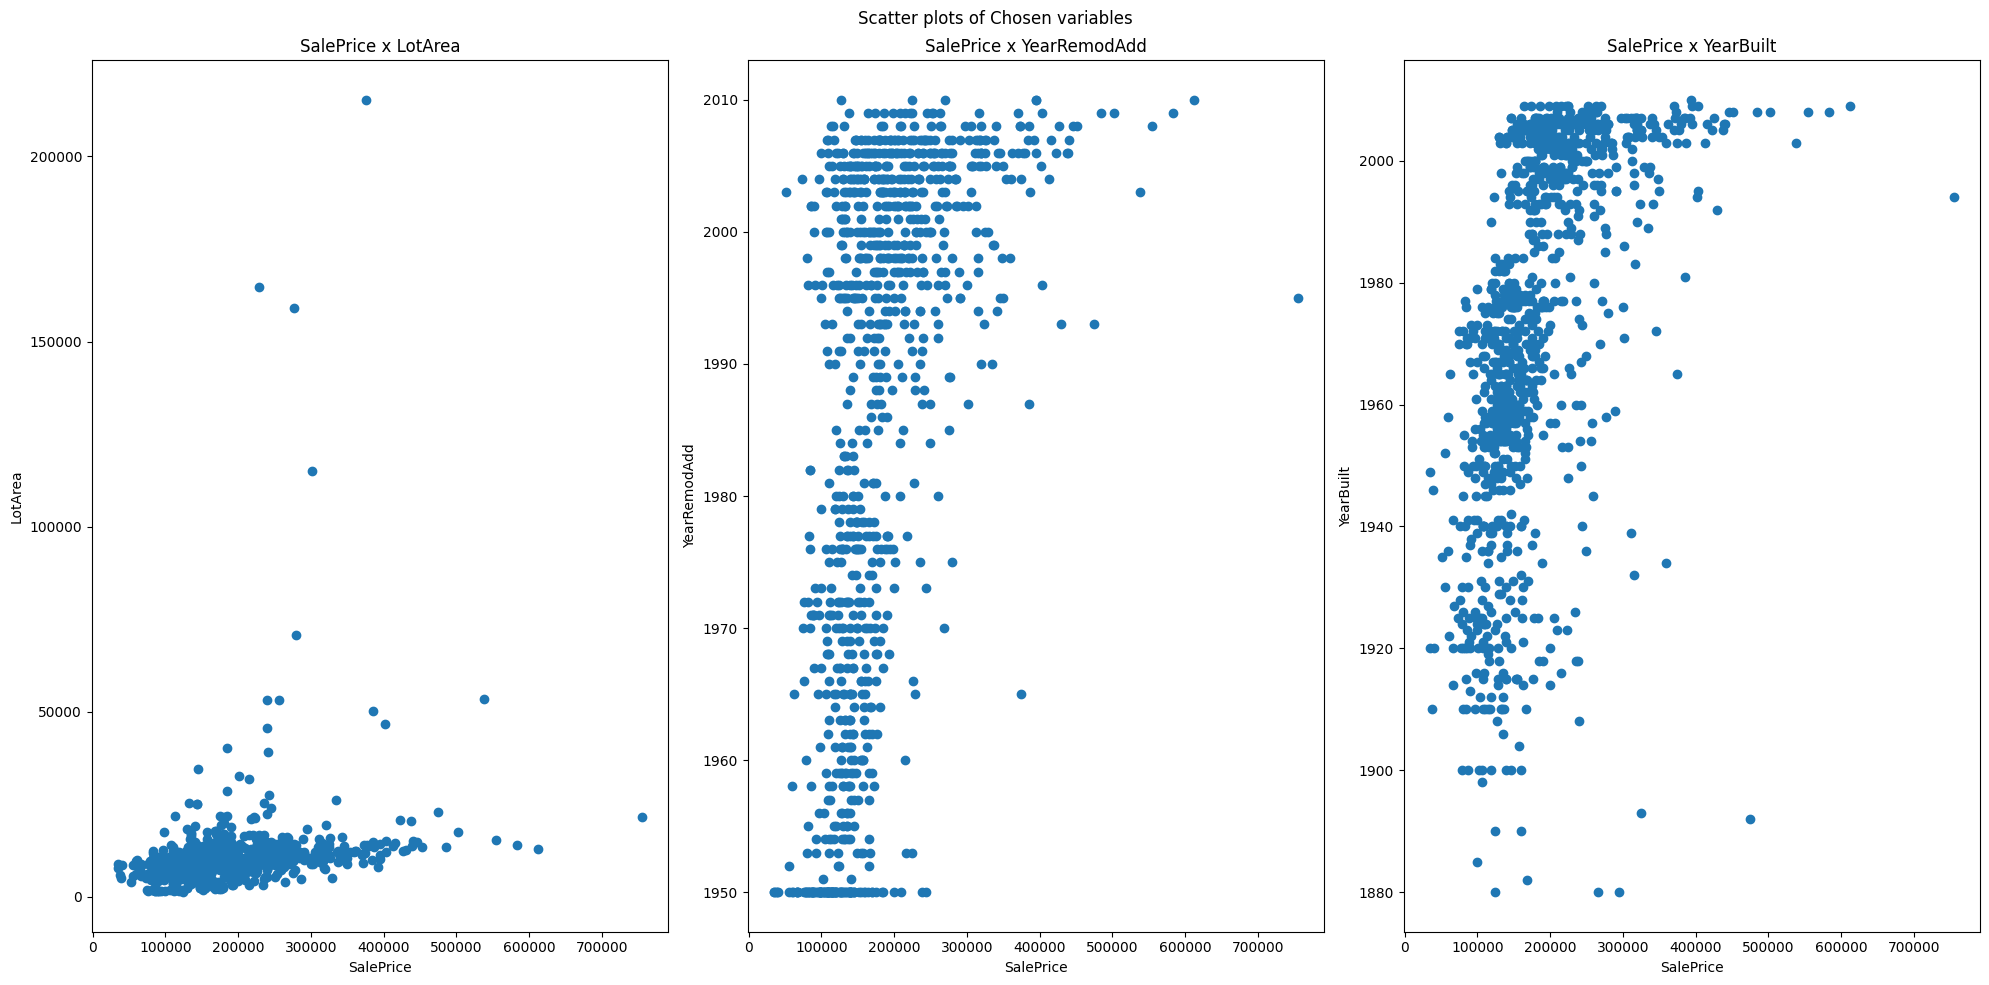

In [8]:
def print_scatters():
    fig, axes = plt.subplots(1, 3, figsize=(20,10))

    fig.suptitle("Scatter plots of Chosen variables")
    feat_scatter =[('SalePrice', 'LotArea'),
                ('SalePrice', 'YearRemodAdd'),
                ('SalePrice', 'YearBuilt')
    ]

    for feat, ax in zip(feat_scatter, axes.flatten()):
        ax.scatter(df[feat[0]], df[feat[1]])
        ax.set_xlabel(feat[0])
        ax.set_ylabel(feat[1])
        ax.set_title(f'{feat[0]} x {feat[1]}')

    plt.tight_layout()
    plt.show()

print_scatters()

# Imputation of NA and outlier values


SalePrice
Outlier count before imputation: 47
(Bounds: lower = 2500.0, upper = 342500.0)
After: 33

LotArea
Outlier count before imputation: 46
(Bounds: lower = 1524.5, upper = 17696.5)
After: 32

OverallQual
Outlier count before imputation: 2
(Bounds: lower = 2.0, upper = 10.0)
After: 0

LotFrontage
Amount of NA values before imputation:  173
After filling NA:  0
Outlier count before imputation: 71
(Bounds: lower = 31.5, upper = 107.5)
After: 61

YearBuilt
Outlier count before imputation: 4
(Bounds: lower = 1885.0, upper = 2069.0)
After: 0

YearRemodAdd
Outlier count before imputation: 0
(Bounds: lower = 1911.5, upper = 2059.5)
After: 0


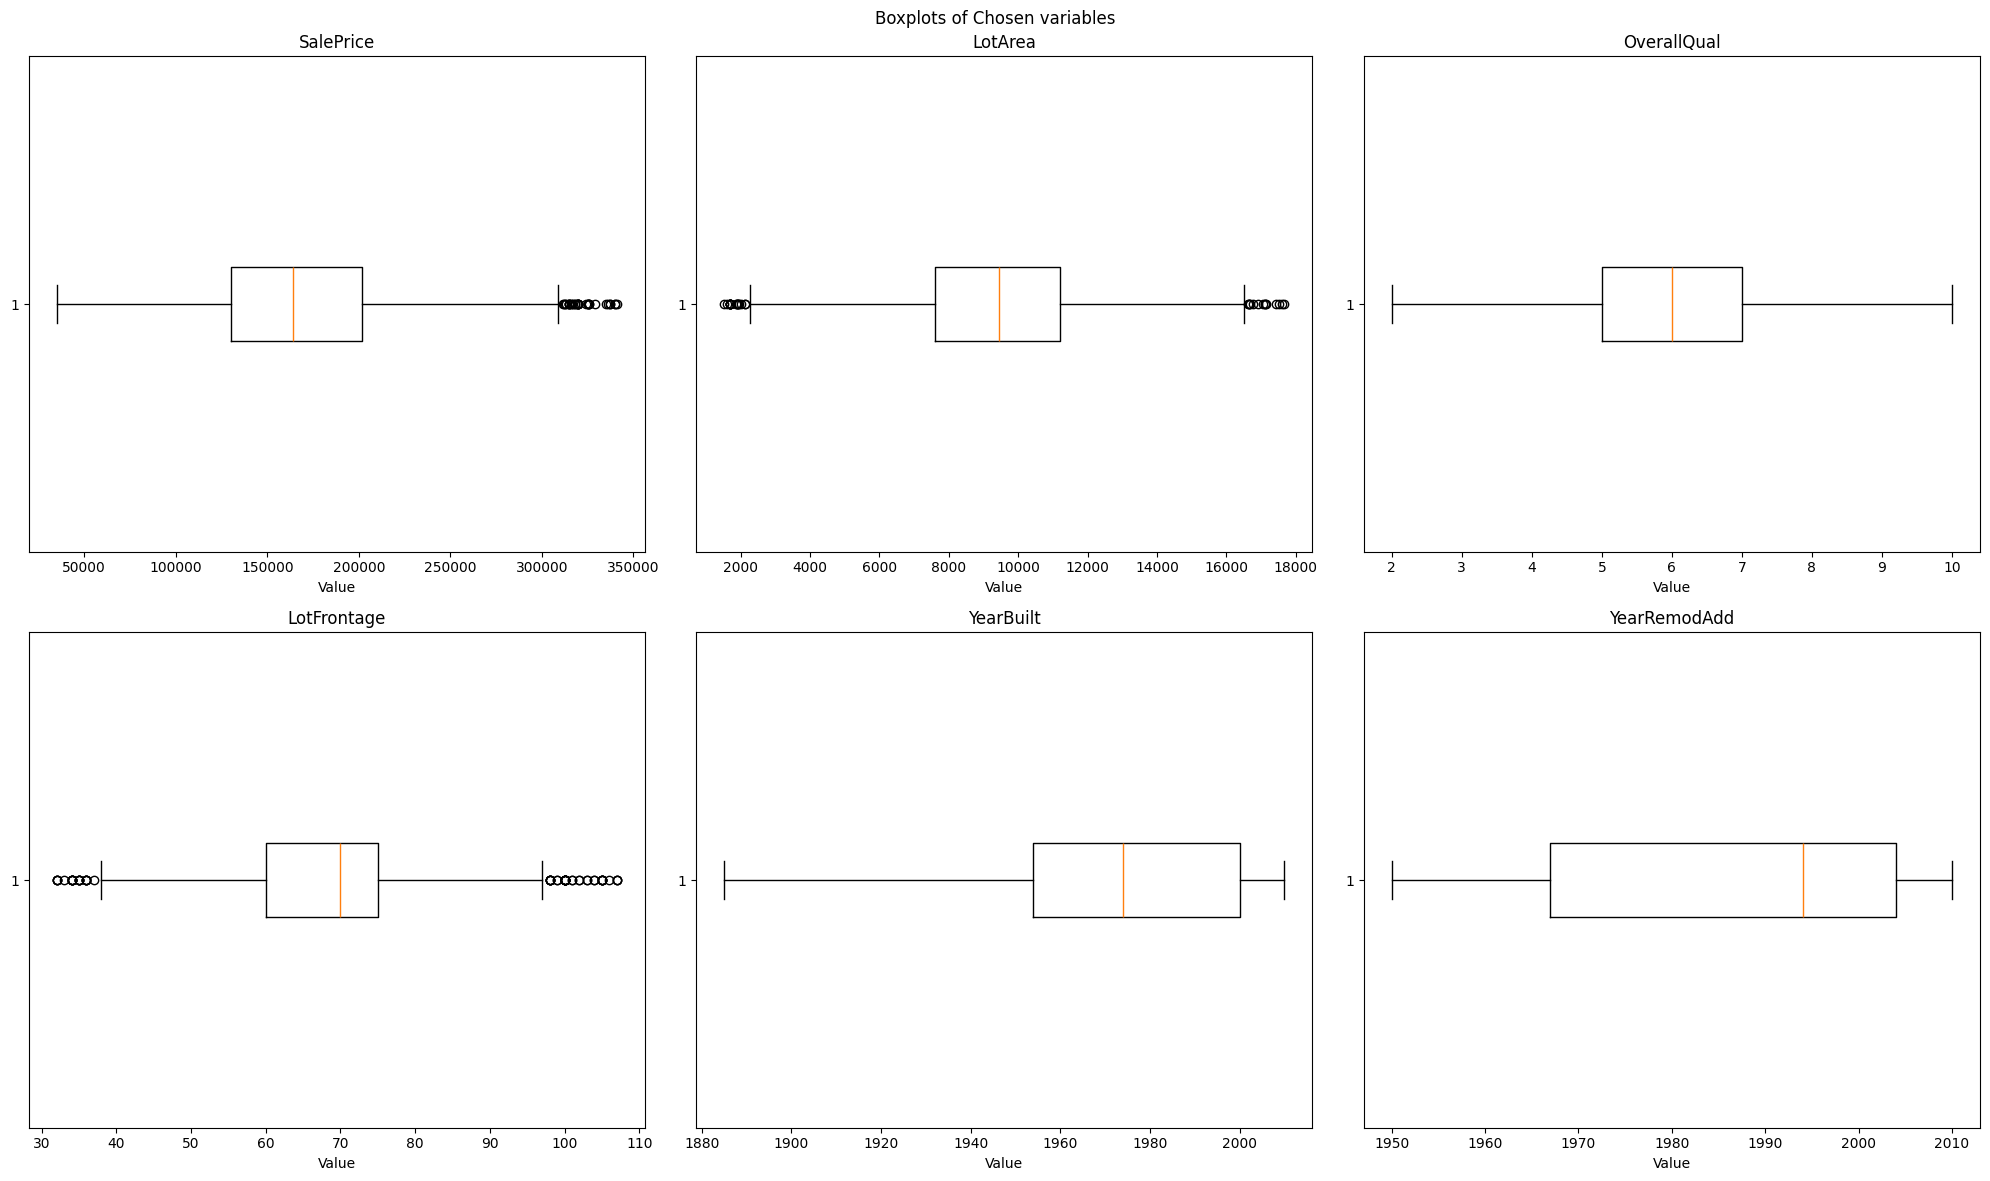

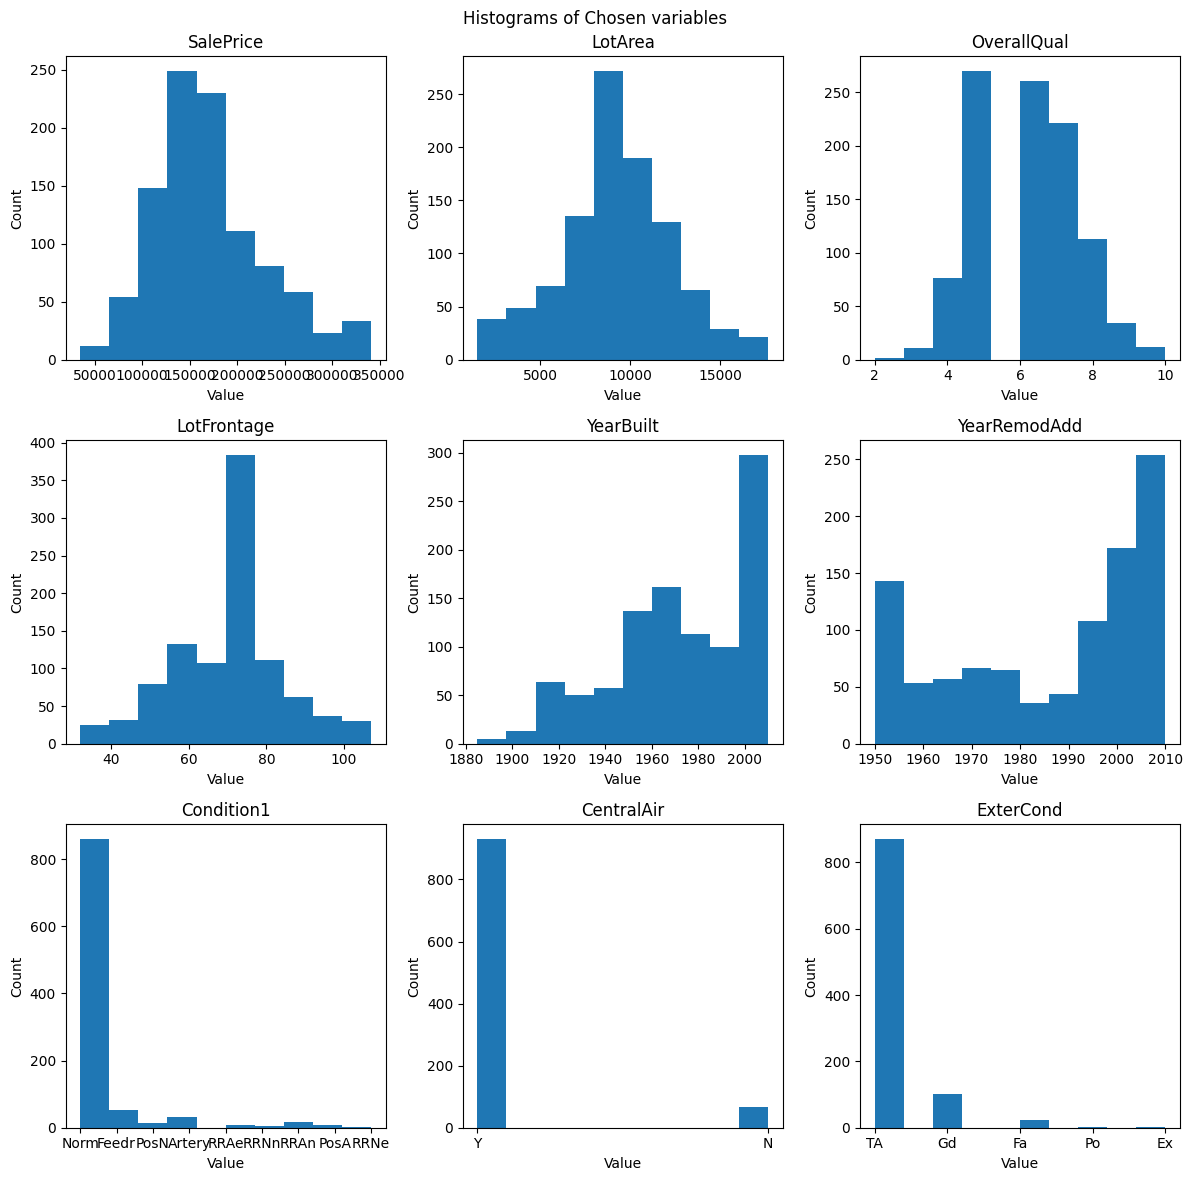

In [9]:
def fill_missing(feat, replace='median'):
    print("Amount of NA values before imputation: ", sum(df[feat].isna()))
    if replace == 'mean':
        val = df[feat].mean() 
    else:
        val = df[feat].median() 
    # Fill na values either with mean or median
    df[feat] = df[feat].fillna(val)
    # obs = obs.fillna(obs.median())
    print("After filling NA: ", sum(df[feat].isna()))

def get_bounds(feat):
    obs = df[feat]
    q1 = obs.quantile(0.25)
    q3 = obs.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    return (lower, upper)

def get_outliers(feat, bounds):
    outliers = []
    for x in df[feat]:
        if (x < bounds[0] or x > bounds[1]):
            outliers.append(x)
    return outliers


def impute_NA_and_outliers(feat, replace='median'):
    print(f'\n{feat}')

    if sum(df[feat].isna())>0:
        fill_missing(feat, replace)

    bounds = get_bounds(feat)
    outliers = get_outliers(feat, bounds)

    if replace == 'median':
        val = df[feat].median()
    else:
        val = df[feat].mean()
    
    df[feat] = df[feat].replace(outliers, val)

    print(f"Outlier count before imputation: {len(outliers)}")
    print(f'(Bounds: lower = {bounds[0]}, upper = {bounds[1]})')

    outliers_left = get_outliers(feat, get_bounds(feat))
    print(f"After: {len(outliers_left)}")

for feat in t_cont['Feature']:
    impute_NA_and_outliers(feat)

print_boxplots()
print_histograms()

# Implementation of KNN algorithm
- Preprocessing:
    - numerical data must first be normalized (z-score)
    - categorical nominal values must be encoded (OneHot)
        - if imbalanced - either duplicate random minority samples or delete random majority samples
- Deciding on K
- Calculating each (Euclidian) distance between the plotted points and the one in questions
- Deciding on the prediction:
    - if numerical - average
    - if categorical - mode
- Optimizing?

# Initialization and preprocessing

In [10]:
seed = 42
col_names = {
    'num':['SalePrice', 'LotArea', 'OverallQual', 'LotFrontage', 'YearBuilt', 'YearRemodAdd'],
    'cat':['Condition1', 'CentralAir', 'ExterCond']
}

pd.set_option('future.no_silent_downcasting', True) # to ignore warning

def preprocess(processed, raw_data, col_names):
    cols = []
    for c in col_names['num'][1:]:
            #z-score normalization
            cols.append((processed[c] - raw_data[c].mean())/raw_data[c].std())

    for c in col_names['cat']:
        uniq = raw_data[c].unique()
        if len(uniq)==2:
            # binary coding
            processed[c] = processed[c].replace(uniq[0], 0)
            processed[c] = processed[c].replace(uniq[1], 1)
            cols.append(processed[c])
        else:
            # one hot
            cols.append(pd.get_dummies(raw_data[c], prefix=c))
    cols.append(processed[col_names['num'][0]])
    return pd.concat(cols, axis = 1)

processed_train = preprocess(df.copy(), df, col_names)
processed_train.head()
# print(processed.columns)

,LotArea,OverallQual,LotFrontage,YearBuilt,YearRemodAdd,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,...,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,CentralAir,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,SalePrice
0,-0.276686,0.634585,-0.305010,1.053847,0.869183,False,False,True,False,False,...,False,False,False,0,False,False,False,False,True,208500
1,0.096570,-0.098306,0.780895,0.136780,-0.453570,False,True,False,False,False,...,False,False,False,0,False,False,False,False,True,181500
2,0.632110,0.634585,-0.087829,0.985916,0.820192,False,False,True,False,False,...,False,False,False,0,False,False,False,False,True,223500
3,0.080341,0.634585,-0.666978,-1.935114,-0.747515,False,False,True,False,False,...,False,False,False,0,False,False,False,False,True,140000
4,1.609065,1.367476,1.070469,0.951951,0.722211,False,False,True,False,False,...,False,False,False,0,False,False,False,False,True,250000


# Getting one test observation to predict

In [11]:
df_test = pd.read_csv('data\\test.csv')
query = df_test.sample(n=1, random_state=42)

processed_query = preprocess(query.copy(), df, col_names).head(1)
processed_query # guess

,LotArea,OverallQual,LotFrontage,YearBuilt,YearRemodAdd,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,...,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,CentralAir,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,SalePrice
225,1.973882,0.634585,-0.666978,1.087813,0.967165,False,False,True,False,False,...,False,False,False,0,False,False,False,False,True,184000.0


# Getting K nearest neighbours

In [12]:
def get_dist(processed_train, processed_query):
    dist_list = []
    shared_features = [x for x in processed_train.columns if x in processed_query.columns]
    processed_query = processed_query[shared_features]
    processed_train = processed_train[shared_features]

    # iterate from 0 to the number of rows in the df
    for i in range(np.shape(processed_train)[0]):
        # Calculate euclidean distance between all observations and the one to predict
        # .iloc[[i],:-1] - selects the i-th row of the df and all columns except the last one,
        # because it is the feature we are trying to predict. [[i]] so that it keeps its shape as a dataframe instead of a series.
        # to_numpy() converts the found row into a numpy array
        # np.linalg.norm - calculates euclidean distance between all features of the iterated and test observation
        d = np.linalg.norm(processed_train.iloc[[i],:-1].to_numpy()-processed_query.iloc[[0],:-1].to_numpy())
        dist_list.append((d, i))

    return dist_list

def get_nearest(processed_train, processed_query, K):
    dist_list = sorted(get_dist(processed_train, processed_query))
    k_nearest_dist = dist_list[:K]
    # * - unpacks the list of tuples,
    # zip - packs the first element of each tuple into one large tuple, same for the other one.
    indices = list(zip(*k_nearest_dist))[1] # get only the indices
    df.loc[indices,:]
    return df.loc[indices,:]

df_nearest = get_nearest(processed_train, processed_query, 8)
df_nearest


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
544,545,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,New,Partial,179665
948,949,60,RL,65.0,14006,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Normal,192500
782,783,20,RL,67.0,16285,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,187100
684,685,60,RL,58.0,16770,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,221000
903,904,20,RL,50.0,14859,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,8,2006,New,Partial,240000
408,409,60,RL,70.0,14154,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,New,Partial,280000
302,303,20,RL,70.0,13704,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2006,WD,Normal,205000
139,140,60,RL,65.0,15426,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,8,2009,WD,Normal,231500


# Predicting the single value

In [13]:
pred = df_nearest['SalePrice'].mean()
actual = query.iloc[0]['SalePrice']
print("Predicted price: ", pred)
print("Actual price: ", actual)

Predicted price:  217095.625
Actual price:  184000


# Evaluating accuracy with test set

In [14]:
# mean absolute percentage error
def get_mape(processed_train:pd.DataFrame, test:pd.DataFrame, n=1):
    processed_test = preprocess(test.copy(), test, col_names)
    sum = 0

    to_predict = processed_test.head(n)

    for i in range(0, n):
        processed_query = to_predict.iloc[[i]]
        df_nearest = get_nearest(processed_train, processed_query, 8)
        actual = df_nearest['SalePrice'].mean()
        pred = processed_query.iloc[0]['SalePrice']
        print(f"Predicted: {pred}")
        print(f"Actual: {actual}")
        sum += np.abs((actual - pred) / actual)

    mape = (1/n) * sum * 100

    return mape
    
print("KNN MAPE = ", get_mape(processed_train, df_test, 10))
    

Predicted: 206000
Actual: 199106.25
Predicted: 82000
Actual: 117656.25
Predicted: 86000
Actual: 123097.5
Predicted: 232000
Actual: 241385.625
Predicted: 136905
Actual: 206687.5
Predicted: 181000
Actual: 190926.5
Predicted: 149900
Actual: 138371.0
Predicted: 163500
Actual: 206687.5
Predicted: 88000
Actual: 116012.5
Predicted: 240000
Actual: 201548.75
KNN MAPE =  17.920515939836402


# K-means

In [15]:
# cluster_count = 3
# centroids = preprocess(df.sample(cluster_count), df, col_names).head(cluster_count)

# # format: [[assigned_cluster, distance_to_assigned_cluster, df_index]]
# assigned_cluster = []
# i = 0
# for c in centroids: 
#     distances = get_dist(processed_train, centroids.iloc[[0]])
#     if i==0:
#         for d in distances:
#             assigned_cluster.append([i, d[0]])
#     else:
#         for d in distances:
#             if d[0]

# assigned_cluster

# get distance between al cluster centroids
# assign to centroid with closest cluster

# 3 clusters
# get distances of all obs between one of the centroids and assign it to the first cluster
# for the second cluster, compare the distance to the one gotten for the previous one. if newly found distance is smaller - assign it to the new cluster
# do so for other clusters

